# 1. Install required libraries

In [1]:
## NOTE: these can fail at installation if running remote server through jupyter notebook -- if you get errors, try installing directly through the R environment terminal with the conda environment activated
# install.packages("ggplot2")
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("Rhdf5lib")
# BiocManager::install("phyloseq")
# BiocManager::install("microbiome")
# install.packages("remotes")
# remotes::install_github("vmikk/metagMisc")
# remotes::install_github("gauravsk/ranacapa")

# 2. Load required libraries

In [2]:
library(ggplot2, verbose=F)
library(phyloseq, verbose=F)
library(ape, verbose=F)
library(metagMisc, verbose=F)
library(plyr, verbose=F)
library(dplyr, verbose=F)
library(vegan, verbose=F)
library(ranacapa, verbose=F)
library(microbiome, verbose=F)

Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:ape’:

    where


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: permute

Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.1.3”
This is vegan 2.6-4


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2021 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

 

# 3. Load in Data, filter & format for phyloseq

NOTE: If data has already been processed, skip to step 4

### 3.1 Load in sequence table, taxonomy table, and mapping file 

In [3]:
set.seed(578934)
# read in ASV and taxonomy tables previously generated
seqtab <- read.table("../01-read_processing/sequence_table.merged.txt", header=T, row.names=1)
tax <- read.table("../01-read_processing/taxonomy_bac.txt", header=F, row.names=1, sep="\t")
# read in metadata file
map <- read.table("../map_domhain_long.txt", sep="\t", header=T, row.names=1)

### 3.2 Check that the same sample names are found in both the sequence table and the mapping file

In [4]:
notinmeta <- setdiff(row.names(seqtab), row.names(map))
notinraw <- setdiff(row.names(map), row.names(seqtab))
print("Samples found in ASV table but not in metadata:")
notinmeta
print("Samples found in metadata but not in sequencing table:")
notinraw

[1] "Samples found in ASV table but not in metadata:"


[1] "PCRBlank1"    "PCRBlank10"   "PCRBlank11"   "PCRBlank12"   "PCRBlank13"  
 [6] "PCRBlank14"   "PCRBlank15"   "PCRBlank16"   "PCRBlank17"   "PCRBlank18"  
[11] "PCRBlank19"   "PCRBlank2"    "PCRBlank20"   "PCRBlank21"   "PCRBlank22"  
[16] "PCRBlank23"   "PCRBlank24"   "PCRBlank25"   "PCRBlank26"   "PCRBlank27"  
[21] "PCRBlank28"   "PCRBlank29"   "PCRBlank3"    "PCRBlank30"   "PCRBlank31"  
[26] "PCRBlank32"   "PCRBlank33"   "PCRBlank34"   "PCRBlank35"   "PCRBlank36"  
[31] "PCRBlank37"   "PCRBlank38"   "PCRBlank39"   "PCRBlank4"    "PCRBlank40"  
[36] "PCRBlank41"   "PCRBlank41-a" "PCRBlank42"   "PCRBlank43"   "PCRBlank44"  
[41] "PCRBlank45"   "PCRBlank46"   "PCRBlank47"   "PCRBlank48"   "PCRBlank49"  
[46] "PCRBlank5"    "PCRBlank50"   "PCRBlank51"   "PCRBlank52"   "PCRBlank53"  
[51] "PCRBlank54"   "PCRBlank55"   "PCRBlank56"   "PCRBlank57"   "PCRBlank58"  
[56] "PCRBlank6"    "PCRBlank60"   "PCRBlank61"   "PCRBlank62"   "PCRBlank63"  
[61] "PCRBlank64"   "PCRBlank65"   "PCRBlank66"   "PCRBlank67"   "PCRBlank68"  
[66] "PCRBlank69"   "PCRBlank7"    "PCRBlank72"   "PCRBlank73"   "PCRBlank74"  
[71] "PCRBlank75"   "PCRBlank76"   "PCRBlank77"   "PCRBlank78"   "PCRBlank79"  
[76] "PCRBlank8"    "PCRBlank80"   "PCRBlank9"

[1] "Samples found in metadata but not in sequencing table:"


character(0)

### 3.3 Add in PCR blanks into mapping file -- print statement should come up as empty

In [5]:
# get current row names
rn <- row.names(map) 
# add in rows for PCR blanks to dataframe
map[nrow(map) + seq_along(notinmeta), ] <- "blank" 
row.names(map) <- c(rn, notinmeta)
# check that it worked
notinmeta <- setdiff(row.names(seqtab), row.names(map))
print("Samples found in ASV table but not in metadata:")
notinmeta

[1] "Samples found in ASV table but not in metadata:"


character(0)

### 3.4 Create initial phyloseq object

In [6]:
ps.dat <- phyloseq(otu_table(seqtab, taxa_are_rows=F), sample_data(map), tax_table(as.matrix(tax)))
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 35952 taxa and 2251 samples ]
sample_data() Sample Data:       [ 2251 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 35952 taxa by 8 taxonomic ranks ]

In [7]:
# colnames(sample_data(ps.dat))

### 3.5 Remove low abundance ASVs

png 
  2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 2251 samples ]
sample_data() Sample Data:       [ 2251 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]

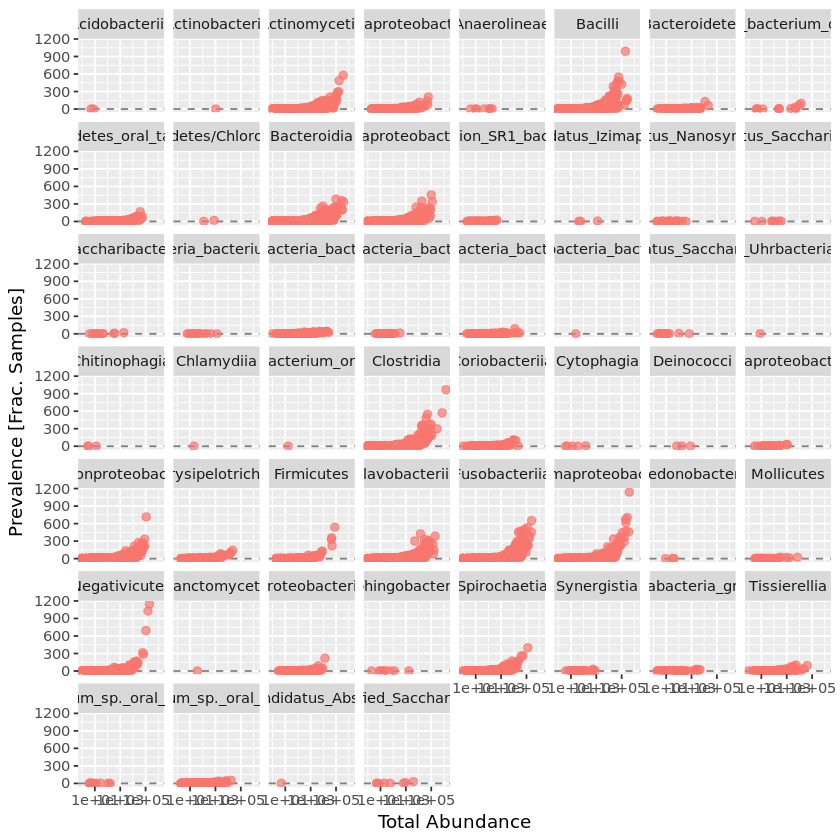

In [8]:
system("mkdir img")
# compute prevalence dataframe
prevdf <- apply(X=otu_table(ps.dat), MARGIN=ifelse(taxa_are_rows(ps.dat), yes=1, no=2), FUN=function(x){sum(x>0)})
# add taxa and total read counts to dataframe
prevdf <- data.frame(Prevalence=prevdf, TotalAbundance=taxa_sums(ps.dat), tax_table(ps.dat))
# which phyla are comprised as mostly low prevalence ASVs?
lowprev <- ggplot(prevdf, aes(TotalAbundance, Prevalence, nsamples(ps.dat), color="V4")) + geom_hline(yintercept=0.05, alpha=0.5, linetype=2) + geom_point(size=2, alpha=0.7) + scale_x_log10() + xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") + facet_wrap(~V4) + theme(legend.position="none")
lowprev
pdf("img/totalabund_vs_prevalence.pdf")
lowprev
dev.off()
# kept asvs must be found in at least 0.1% of all samples (~2) or have a total abundance of 1000 reads or more
ps.dat <- phyloseq_filter_prevalence(ps.dat, prev.trh=0.001, abund.trh=1000, threshold_condition="OR")
ps.dat

### 3.6 Remove samples with low read counts

In [9]:
# read count summary before filter
summary(rowSums(otu_table(ps.dat)))
ps.dat <- prune_samples(sample_sums(ps.dat) > 5000, ps.dat)
ps.dat
# read count after filter
summary(rowSums(otu_table(ps.dat)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0   15558   25966   26258   35257  274013 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1978 samples ]
sample_data() Sample Data:       [ 1978 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5017   20238   28170   29603   37034  274013 

### 3.7 Blanks analysis

We run molecular grade water alongside true samples to track sources of contamination. If blanks are filtered out during preprocessing or quality filtering we ignore those samples. Blanks that pass these filtering steps need to be interrogated further

In [10]:
# how many blanks are left after fitering?
blanks <- subset_samples(ps.dat, sample_type=="blank")
blanks <- prune_taxa(taxa_sums(blanks) > 1, blanks)
blanks
rownames(sample_data(blanks))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 125 taxa and 2 samples ]
sample_data() Sample Data:       [ 2 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 125 taxa by 8 taxonomic ranks ]

[1] "PCRBlank62" "PCRBlank65"

In [11]:
# two blanks have passed our filtering steps -- top taxa detected?
rel.abund <- transform_sample_counts(blanks, function(x) x/sum(x)) # get relative abundance
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[6]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V7 <- as.character(data$V7) # convert to character
data$V7[data$Abundance < 0.05] <- "< 5% abund" # rename low freq phyla
avs <- plyr::ddply(data, ~V7, function(x) c(mean=mean(x$Abundance)))
avs                   

V7,mean
<chr>,<dbl>
< 5% abund,0.01277106
Campylobacter,0.18199979
Capnocytophaga,0.10774902
Lachnoanaerobaculum,0.11460893
Leptotrichia,0.06912314
Prevotella,0.06676112


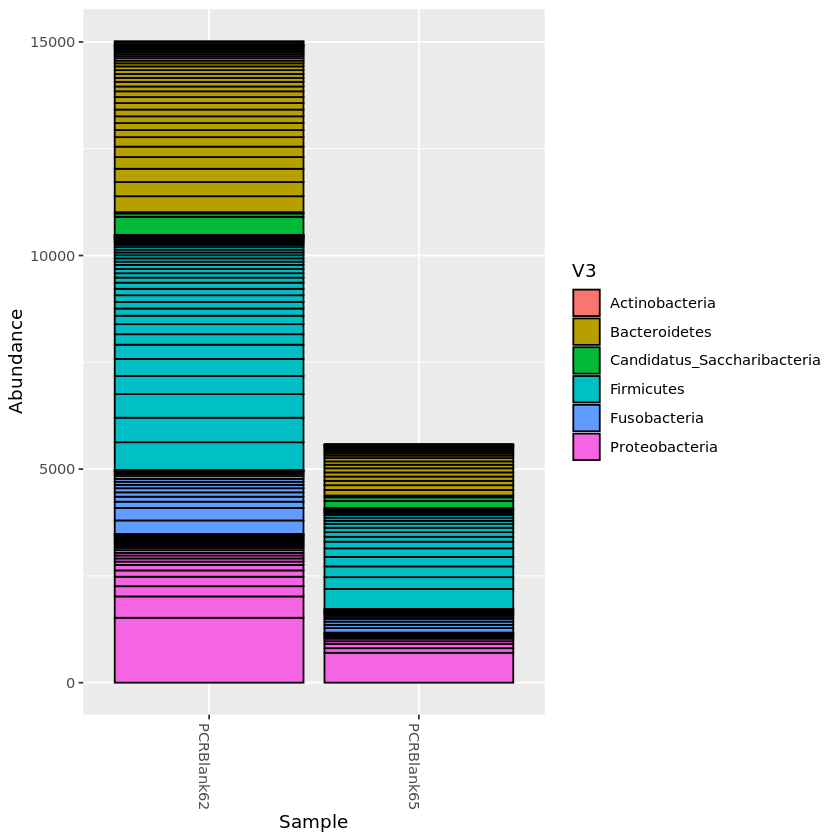

In [12]:
# what proportion of each found in the blanks?
plot_bar(blanks, fill="V3")

So these two blanks are worrisome because they 1: have a relatively high number of reads and 2: they include taxa we would typically see in the oral cavity. That being said, the proportion of reads is not what you might expect from a true plaque sample (for example, note the lack/low proportion of Streptococcus). 

Going back to lab notebooks, PCRBlank65 can be ignored --> samples that were initially processed with this blank were re run as it had a relatively high qubit value. PCRBlank66 (filtered out in early processing steps) corresponds to these samples. 

PCRBlank62, on the other hand is problematic. Lab notebook page that corresponds to this PCR --> CA lab notebook, run on 07/07/22. This sample was also quite high on the qubit (4.39 ng/ul) but was not visible on gel (see AEM lab notebook 2 pg. 74) so was not re processed. Because we cannot rule out cross contamination, will need to remove samples that were processed along with this blank.

In [13]:
# before
ps.dat
# remove possible contaminated samples
remsamps <- c("DM00048V3PQ16", "DM00048V3PQ65", "DM0048V3PQ84", "DM00049V3PQ16", "DM00050V3PQ54", "DM00050V3PQ55", "DM0051V3PQ16", "DM00052V3PQ16", "DM00053V3PQ26-36", "DM00054V3PQ55", "DM00055V3PQ75", "DM00056V3PQ16", "DM00057V3PQ16", "DM00058V3PQ16", "DM00059V3PQ55", "DM00059V3PQ74", "DM00060V3PQ46", "DM00061V3PQ16", "DM00061V3PQ46", "DM00062V3PQ16", "DM00062V3PQ75")
ps.dat <- subset_samples(ps.dat, !(rownames(sample_data(ps.dat)) %in% remsamps))
# now remove blanks
ps.dat <- subset_samples(ps.dat, sample_type=="plaque")
# after
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1978 samples ]
sample_data() Sample Data:       [ 1978 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]

### 3.8 Write list of ASVs to keep to file, filter representative sequence set, build neighbor joining tree from filtered data

In [14]:
write.table(as.data.frame(row.names(tax_table(ps.dat))), file="asvs_to_keep", sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)
system("/home/$USER/miniconda3/envs/2023-Long_oral_microbiome/bin/seqtk subseq ../01-read_processing/rep_set.fa asvs_to_keep > rep_set.filt.fa")
system("/home/$USER/miniconda3/envs/2023-Long_oral_microbiome/bin/mafft --thread 8 rep_set.filt.fa > rep_set.align.fa")
# system("iqtree -s rep_set.align.fa -m MFP --seqtype DNA -T 60 1>iqtree.out 2>iqtree.err") # using modelfinder to select best phylo model
# fasttree neighbor joining tree
system("/home/$USER/miniconda3/envs/2023-Long_oral_microbiome/bin/fasttree -noml -nt rep_set.align.fa  > rep_set.nj.tre")

### 3.9 Read in newly generated tree, add to existing phyloseq object

In [15]:
# read in tree, merge with phyloseq object
tree <- read.tree("rep_set.nj.tre")
ps.dat <- merge_phyloseq(ps.dat, tree)
ps.dat 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

### 3.10 Write out filtered ASV table, taxonomy, and metadata to file

In [16]:
write.table(as.data.frame(otu_table(ps.dat)), "sequence_table.filt.txt", sep="\t", row.names=T, col.names=T, quote=F)
# write filtered taxonomy to file
write.table(as.data.frame(tax_table(ps.dat)), "taxonomy_bac.filt.txt", sep="\t", row.names=T, col.names=T, quote=F)
# filtered metadata
write.table(as.data.frame(sample_data(ps.dat)), "map.filt.txt", sep="\t", row.names=T, col.names=T, quote=F)

### 3.11  Save R image 

In [3]:
# save.image("master_phyloseq.RData")
# or load saved image
load("master_phyloseq.RData")

### 3.12 Run other analysis notebooks

In [18]:
## Top ASVs analyses
system("jupyter nbconvert --execute --to notebook --inplace top_ASVs.ipynb &")
## Differential abundance health vs disease
system("jupyter nbconvert --execute --to notebook --inplace diffabund_healthvdisease.ipynb &")
## Volatility analyses
system("jupyter nbconvert --execute --to notebook --inplace ../03-volatility/volatility.ipynb &")
## CD4 analyses
system("jupyter nbconvert --execute --to notebook --inplace ../08-CD4_counts/cd4_counts.ipynb &")
## Spatial analyses
system("jupyter nbconvert --execute --to notebook --inplace ../04-biogeography/spatial_stability_HCF.ipynb &")
# ## Network analyses
# system("jupyter nbconvert --execute --to notebook --inplace ../05-networks/networks.ipynb &")

# 4. Dataset summary

### 4.1 Sample summary

png 
  2

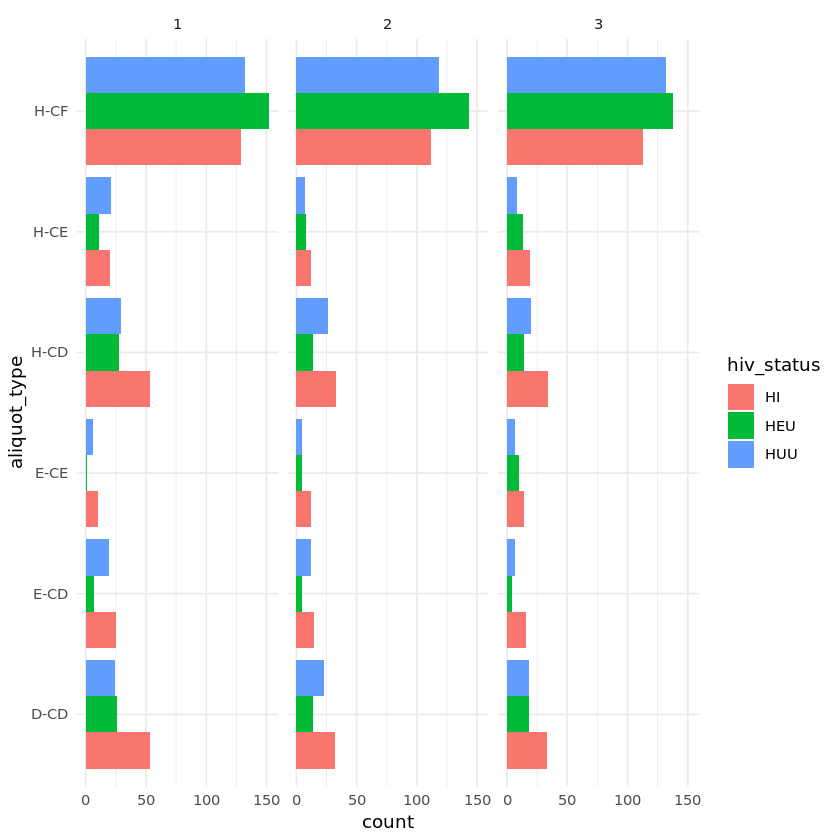

In [4]:
# colnames(sample_data(ps.dat))
temp <- as.data.frame(cbind(sample_data(ps.dat)$aliquot_type, sample_data(ps.dat)$hiv_status, sample_data(ps.dat)$visit_num))
colnames(temp) <- c("aliquot_type", "hiv_status", "visit")
temp <- ddply(temp, .(temp$aliquot_type, temp$hiv_status, temp$visit), nrow)
colnames(temp) <- c("aliquot_type", "hiv_status", "visit", "count")
temp$visit <- as.character(temp$visit)
temp$hiv_status <- factor(temp$hiv_status, levels=c("HI", "HEU", "HUU"))
# plot
temp <- na.omit(temp)
ggplot(temp, aes(aliquot_type, count)) + geom_bar(aes(fill=hiv_status), position="dodge", stat="identity") + 
    theme_minimal() +
    coord_flip() +
    facet_wrap(~temp$visit) 
pdf("img/sample_summary.pdf")
ggplot(temp, aes(aliquot_type, count)) + geom_bar(aes(fill=hiv_status), position="dodge", stat="identity") + 
    theme_minimal() +
    coord_flip() +
    facet_wrap(~temp$visit) 
dev.off()

In [5]:
# some summary statistics describing the data
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

### 4.2 Top phyla in full dataset

In [6]:
options(getClass.msg=FALSE) # this is supposed to suppress class warnings but clearly does not work :|
rel.abund <- transform_sample_counts(ps.dat, function(x) x/sum(x)) # get relative abundance
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[2]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V3 <- as.character(data$V3) # convert to character
data$V3[data$Abundance < 0.05] <- "< 5% abund" # rename low freq phyla
avs <- plyr::ddply(data, ~V3, function(x) c(mean=mean(x$Abundance)))
avs
write.table(avs, "average_abund_phyla.txt", sep="\t", row.names=FALSE, col.names=FALSE, quote=FALSE)

V3,mean
<chr>,<dbl>
< 5% abund,0.002948935
Actinobacteria,0.159640283
Bacteroidetes,0.309333431
Candidatus_Saccharibacteria,0.112799595
Firmicutes,0.256341498
Fusobacteria,0.153331024
Proteobacteria,0.211709603
Spirochaetes,0.079600280
Terrabacteria_group,0.061291481


### 4.3 Taxonomy barchart at phylum level

`summarise()` has grouped output by 'hiv_status', 'aliquot_type'. You can
override using the `.groups` argument.


png 
  2

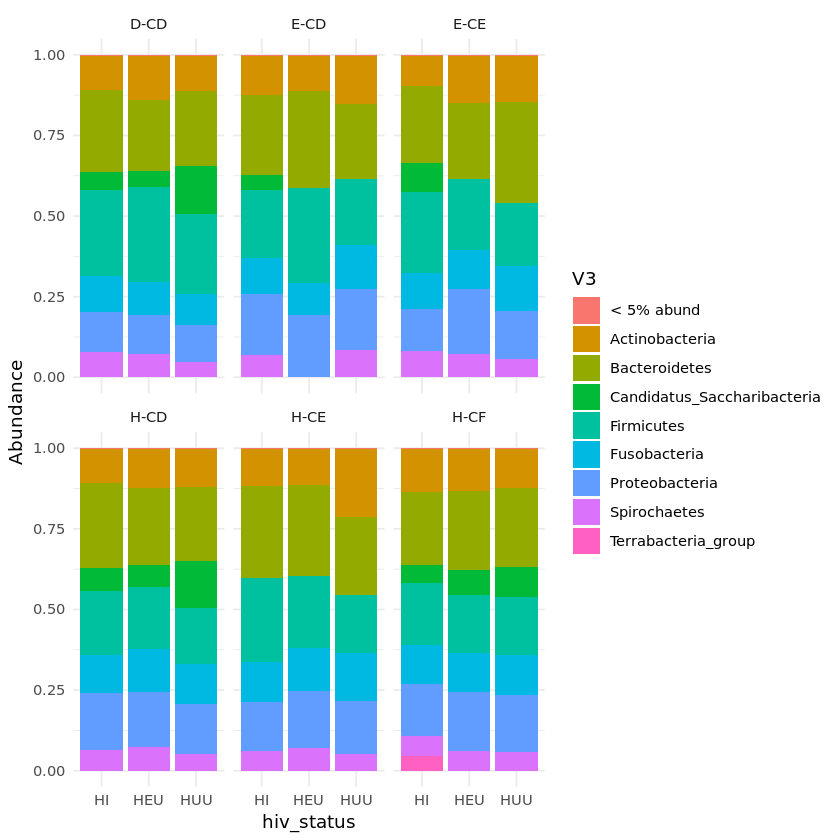

In [7]:
grouped <- data %>% group_by(hiv_status, aliquot_type, V3) %>% summarize(Abundance = mean(Abundance))
# get correct order of group factors
grouped$hiv_status <- as.character(grouped$hiv_status)
grouped$hiv_status <- factor(grouped$hiv_status, levels=c("HI", "HEU", "HUU"))
taxbarphy <- ggplot(grouped, aes(fill=V3, y=Abundance, x=hiv_status)) + geom_bar(position="fill", stat="identity") + facet_wrap(~aliquot_type) + theme_minimal()
pdf("img/grouped_tax_barchart.pdf")
taxbarphy
dev.off()
taxbarphy

### 4.4 Top genera in full dataset

In [8]:
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[7]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V7 <- as.character(data$V7) # convert to character
data$V7[data$Abundance < 0.45] <- "< 45% abund" # rename low freq phyla
avs <- plyr::ddply(data, ~V7, function(x) c(median=median(x$Abundance)))
avs
write.table(avs, "average_abund_genera.txt", sep="\t", row.names=FALSE, col.names=FALSE, quote=FALSE)

V7,median
<chr>,<dbl>
< 45% abund,0.0000000
Atopobiaceae,0.5150318
Candidatus_Saccharibacteria_bacterium_oral_taxon_957,0.5055535
Capnocytophaga,0.5530546
Cardiobacterium,0.5148188
Lachnospiraceae_bacterium_oral_taxon_096,0.4698717
Leptotrichia,0.4724794
Ligilactobacillus,0.6405971
Neisseria,0.4509958


# 5. Beta diversity

In [9]:
# set up some color palettes for major groupings
hivCols <- c("#8213A0", "#FA78FA", "#40A0FA")
healthCols <- c("#AA0A3B", "#F87850", "#F0F032", "#2F5AC8", "#3FD2DC", "#24B45A")

### 5.1 CLR transformation

In [10]:
ps.dat.clr <- microbiome::transform(ps.dat, transform="clr", target="OTU")

### 5.2 Distance based redundancy analysis

png 
  2

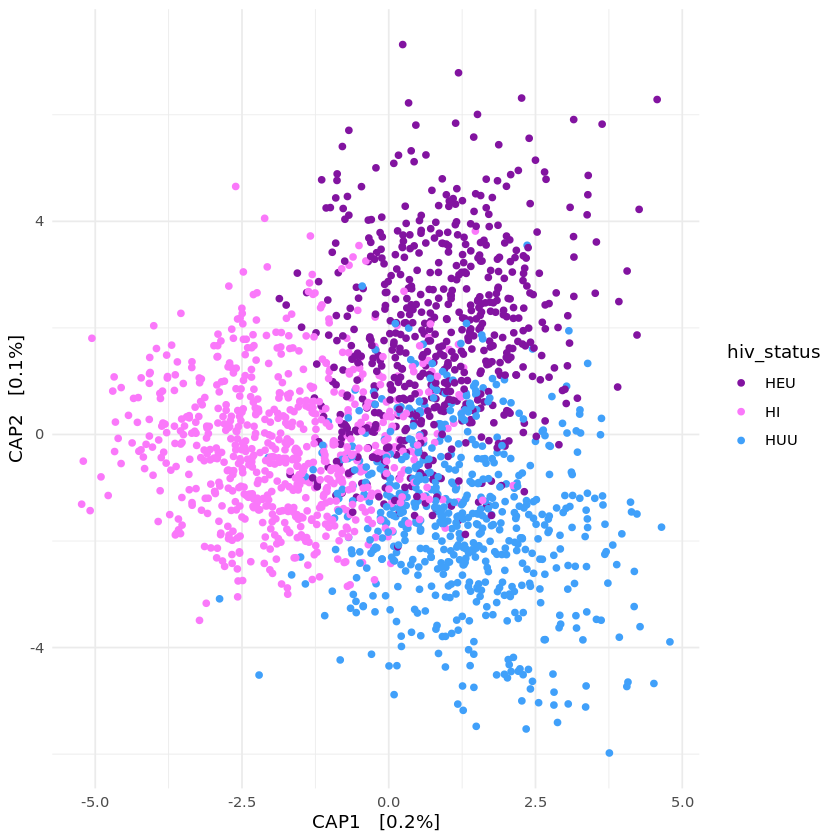

In [11]:
ordcap <- ordinate(ps.dat.clr, "CAP", "euclidean", ~hiv_status)
# capscale plot by HIV status group
pdf("img/bdiv_cap.hiv_status.pdf")
plot_ordination(ps.dat.clr, ordcap, "samples", color="hiv_status") + 
    theme_minimal() + 
    scale_color_manual(values=hivCols)
dev.off()
plot_ordination(ps.dat.clr, ordcap, "samples", color="hiv_status") + 
    theme_minimal() + 
    scale_color_manual(values=hivCols)

png 
  2

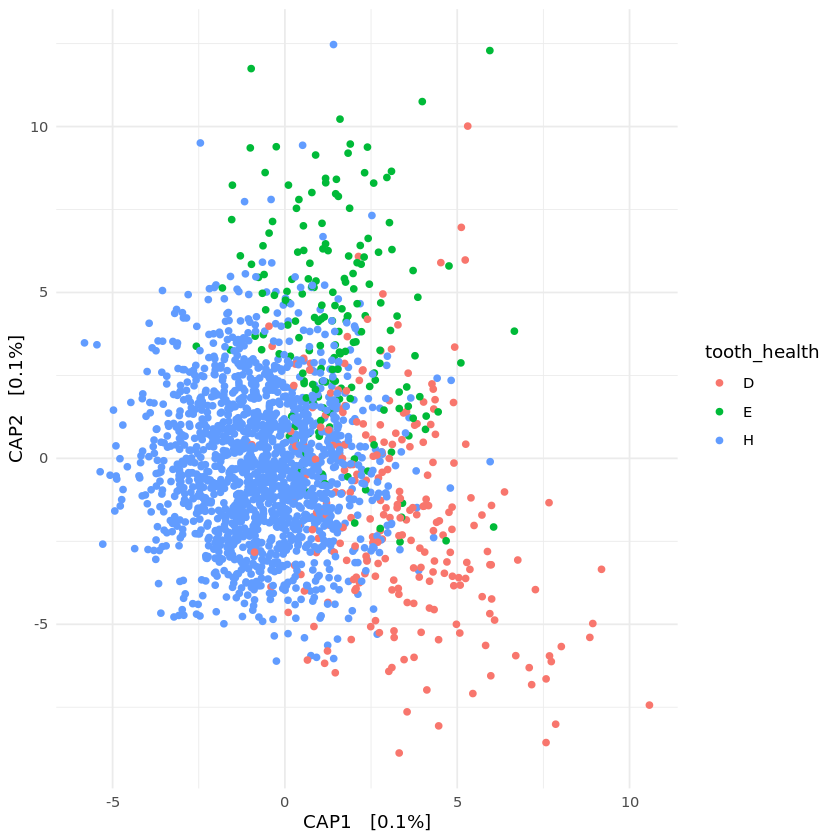

In [12]:
# now by tooth health category
ordcap <- ordinate(ps.dat.clr, "CAP", "euclidean", ~tooth_health)
pdf("img/bdiv_cap.tooth_health.pdf")
plot_ordination(ps.dat.clr, ordcap, "samples", color="tooth_health") + 
    theme_minimal()
dev.off()
plot_ordination(ps.dat.clr, ordcap, "samples", color="tooth_health") + 
    theme_minimal()

png 
  2

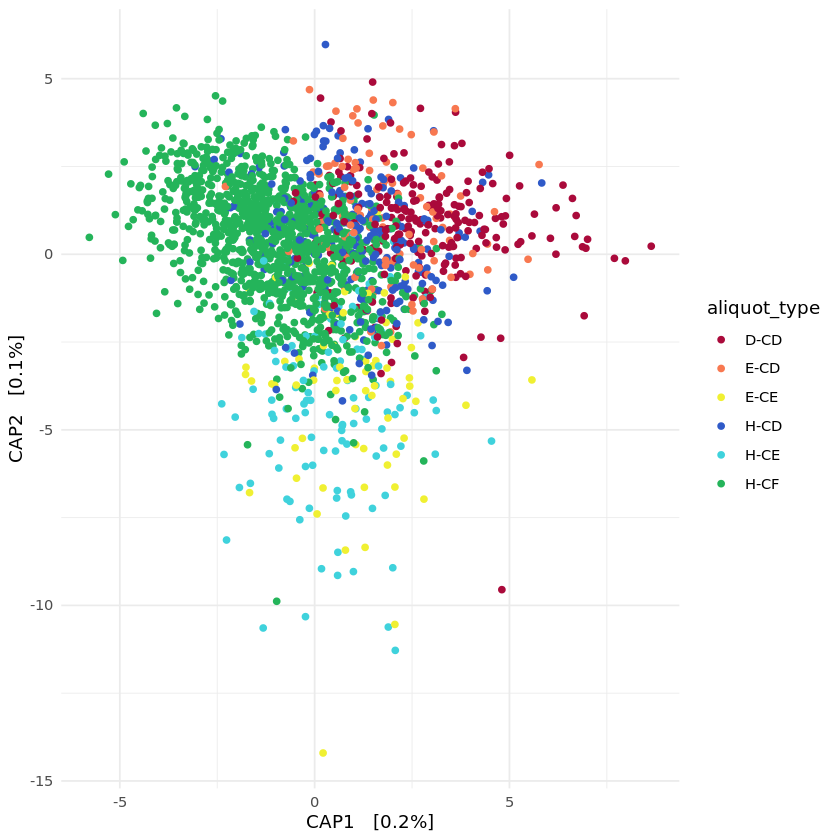

In [13]:
# aliquot type
ordcap <- ordinate(ps.dat.clr, "CAP", "euclidean", ~aliquot_type)
pdf("img/bdiv_cap.aliquot_type.pdf")
plot_ordination(ps.dat.clr, ordcap, "samples", color="aliquot_type") + 
    theme_minimal() +
    scale_color_manual(values=healthCols)
dev.off()
plot_ordination(ps.dat.clr, ordcap, "samples", color="aliquot_type") + 
    theme_minimal() +
    scale_color_manual(values=healthCols)

png 
  2

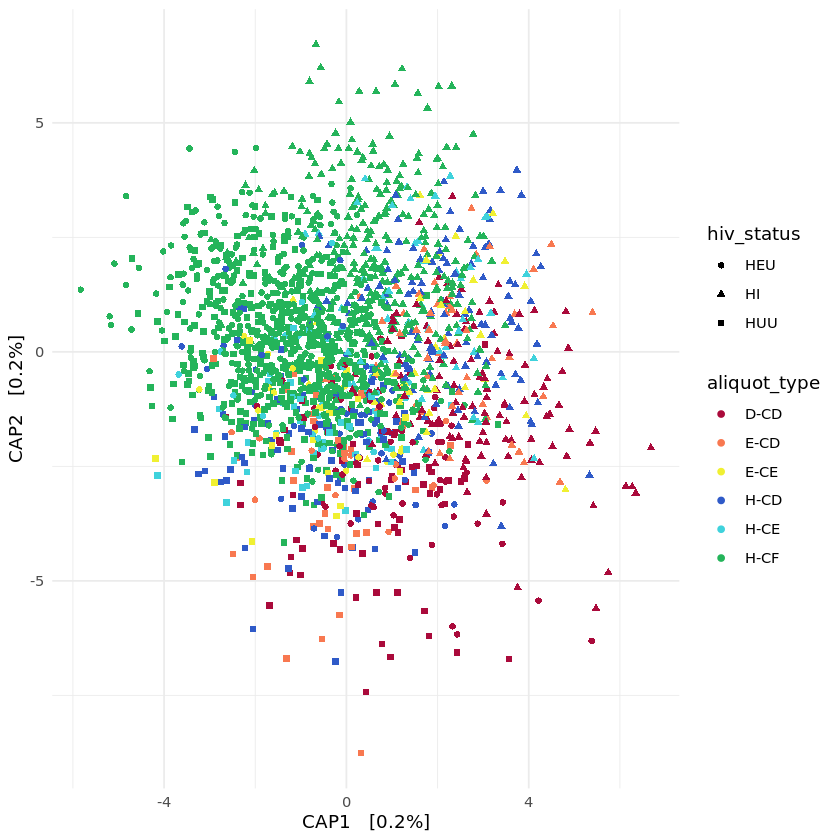

In [14]:
# by aliquot_type + HIV status?
ordcap <- ordinate(ps.dat.clr, "CAP", "euclidean", ~hiv_status + aliquot_type)
# capscale plot by HIV status group
pdf("img/bdiv_cap.hiv_status.aliquot_type.pdf")
plot_ordination(ps.dat.clr, ordcap, "samples", color="aliquot_type", shape="hiv_status") + 
    theme_minimal() +
    scale_color_manual(values=healthCols)
dev.off()
plot_ordination(ps.dat.clr, ordcap, "samples", color="aliquot_type", shape="hiv_status") + 
    theme_minimal() +
    scale_color_manual(values=healthCols)

### 5.3 Beta dispersion 

In [15]:
# first pull sample data from phyloseq object
metadata <- as(sample_data(ps.dat.clr), "data.frame")
# calculate aitchison distance (from CLR transformed data)
clr.dist <- dist(otu_table(ps.dat.clr), method="euclidean")

[1] "Beta disperson HIV status"



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = clr.dist, group =
phyloseq::sample_data(ps.dat.clr)$hiv_status)

No. of Positive Eigenvalues: 1959
No. of Negative Eigenvalues: 0

Average distance to median:
  HEU    HI   HUU 
82.71 80.75 81.01 

Eigenvalues for PCoA axes:
(Showing 8 of 1959 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
206493 150802 113922  89675  65516  58981  58144  53195 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df Sum Sq Mean Sq      F N.Perm Pr(>F)  
Groups       2   1461  730.68 3.8649    999  0.017 *
Residuals 1957 369984  189.06                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

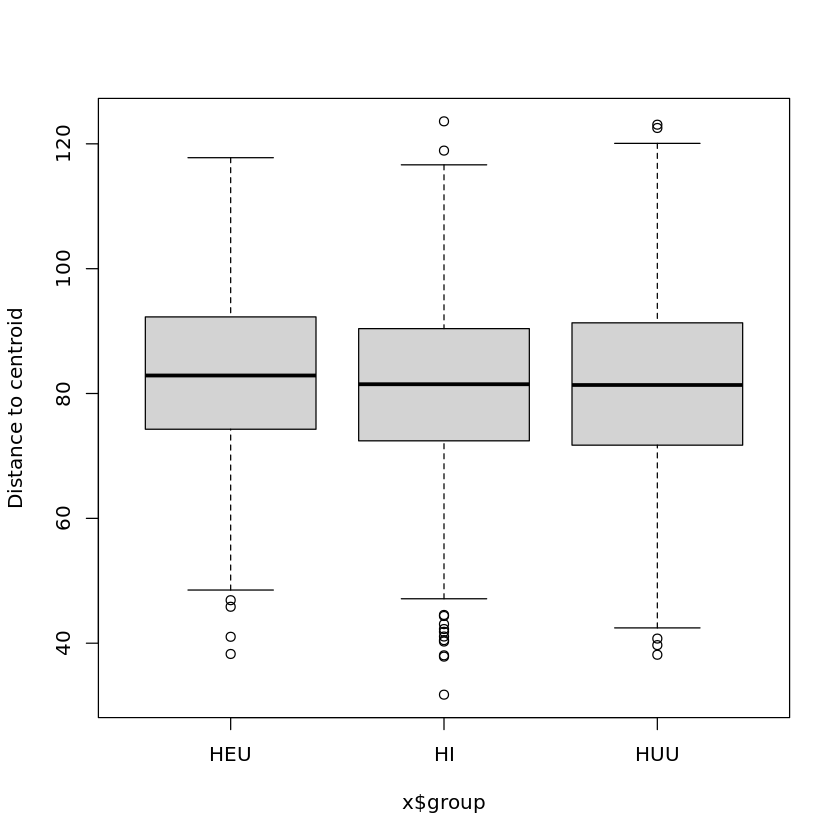

In [16]:
dispr <- vegan::betadisper(clr.dist, phyloseq::sample_data(ps.dat.clr)$hiv_status)
print("Beta disperson HIV status")
dispr
permutest(dispr)
betadis <- boxplot(dispr)

[1] "Beta disperson aliquot type"



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = clr.dist, group =
phyloseq::sample_data(ps.dat.clr)$aliquot_type)

No. of Positive Eigenvalues: 1959
No. of Negative Eigenvalues: 0

Average distance to median:
 D-CD  E-CD  E-CE  H-CD  H-CE  H-CF 
77.97 81.69 78.95 82.62 81.90 81.89 

Eigenvalues for PCoA axes:
(Showing 8 of 1959 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
206493 150802 113922  89675  65516  58981  58144  53195 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df Sum Sq Mean Sq      F N.Perm Pr(>F)   
Groups       5   3948  789.66 4.1728    999  0.002 **
Residuals 1954 369776  189.24                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

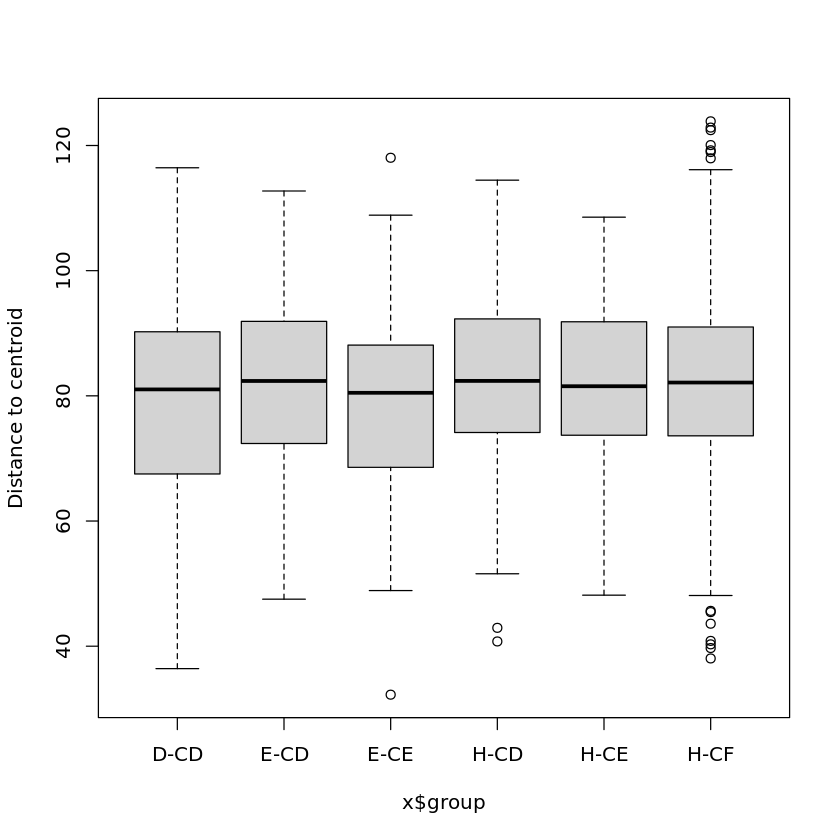

In [17]:
dispr <- vegan::betadisper(clr.dist, phyloseq::sample_data(ps.dat.clr)$aliquot_type)
print("Beta disperson aliquot type")
dispr
permutest(dispr)
betadis <- boxplot(dispr)

### 5.4 PERMANOVA analysis

In [18]:
metadata <- as(sample_data(ps.dat.clr), "data.frame")

In [19]:
adonis2(clr.dist ~ hiv_status * aliquot_type * sex * age_y, data=metadata)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hiv_status,2,40215.98,0.002999428,3.036530,0.001
aliquot_type,5,56177.19,0.004189863,1.696676,0.001
sex,1,15193.60,0.001133184,2.294403,0.001
age_y,8,111381.20,0.008307142,2.102475,0.001
hiv_status:aliquot_type,10,87640.12,0.006536461,1.323463,0.001
hiv_status:sex,2,26797.32,0.001998624,2.023346,0.001
aliquot_type:sex,5,43151.92,0.003218399,1.303284,0.001
hiv_status:age_y,16,168844.05,0.012592893,1.593583,0.001
aliquot_type:age_y,37,268332.98,0.020013074,1.095169,0.001


# 6. Alpha diversity


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate


The following object is masked from ‘package:ape’:

    rotate




png 
  2

png 
  2

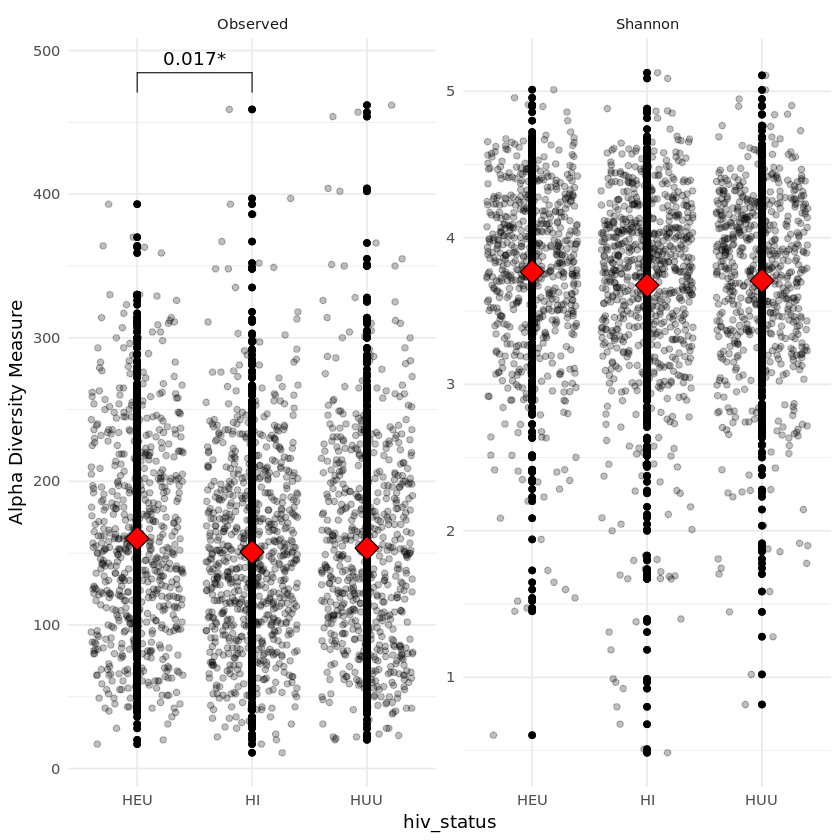

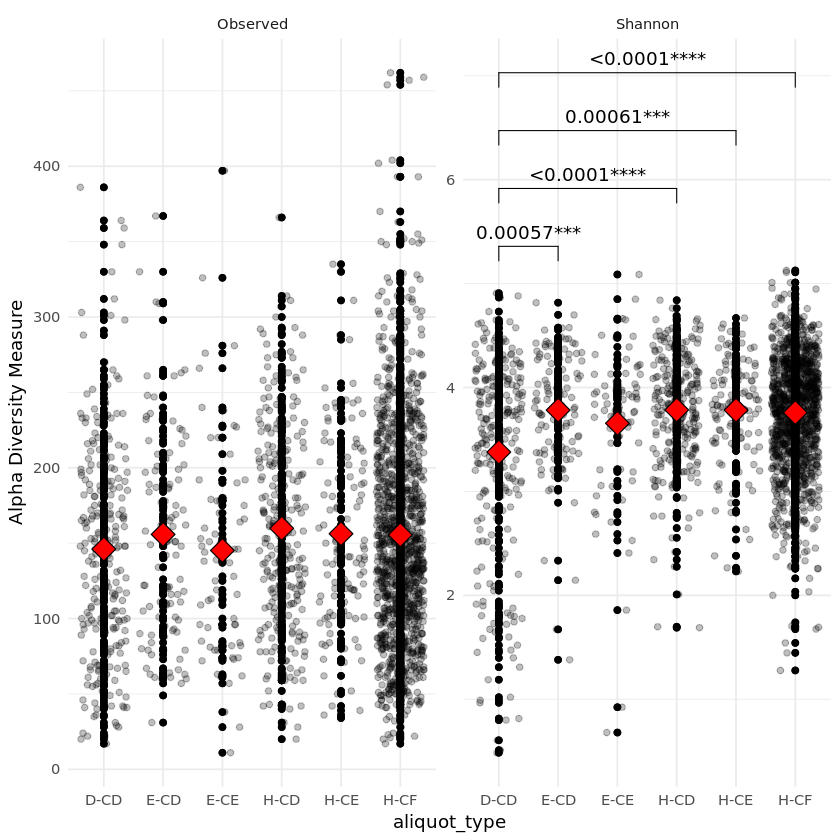

In [20]:
# install.packages("ggpubr")
library(ggpubr)
# alpha diversity by hiv status
# NOTE: Using non transformed data
pdf("img/adiv.hiv_status.pdf")
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="hiv_status") + 
    theme_minimal() + 
    geom_jitter(alpha=0.25) +
    geom_pwc(label = "{p.format}{p.signif}", hide.ns =TRUE, p.adjust.method = "fdr") +
    geom_point() +
    stat_summary(
    geom = "point",
    fun = "mean",
    col = "black",
    size = 5,
    shape = 23,
    fill = "red"
  )
dev.off()
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="hiv_status") + 
    theme_minimal() + 
    geom_jitter(alpha=0.25) +
    geom_pwc(label = "{p.format}{p.signif}", hide.ns =TRUE, p.adjust.method = "fdr") +
    geom_point() +
    stat_summary(
    geom = "point",
    fun = "mean",
    col = "black",
    size = 5,
    shape = 23,
    fill = "red"
  )

# alpha diversity by aliquot type
pdf("img/adiv.aliquot_type.pdf")
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="aliquot_type") + 
    theme_minimal() + 
    geom_jitter(alpha=0.25) +
    geom_pwc(label = "{p.format}{p.signif}", hide.ns =TRUE, p.adjust.method = "fdr") +
    geom_point() +
    stat_summary(
    geom = "point",
    fun = "mean",
    col = "black",
    size = 5,
    shape = 23,
    fill = "red"
  )
dev.off()
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="aliquot_type") + 
    theme_minimal() + 
    geom_jitter(alpha=0.25) +
    geom_pwc(label = "{p.format}{p.signif}", hide.ns =TRUE, p.adjust.method = "fdr") +
    geom_point() +
    stat_summary(
    geom = "point",
    fun = "mean",
    col = "black",
    size = 5,
    shape = 23,
    fill = "red"
  )

shannon diversity not significantly different between healthy teeth of any oral health group. D-CD has lowest diversity (expected), significantly lower than E-CD and all three H categories

### 6.1 Rarefaction analysis

rarefying sample DM00001V1PQ
rarefying sample DM00001V2PQ16
rarefying sample DM00003V3PQ16
rarefying sample DM00003V3PQ55
rarefying sample DM00004V3PQ16
rarefying sample DM00005V2PQ16
rarefying sample DM00005V3PQ16
rarefying sample DM00006V1PQ1
rarefying sample DM00006V2PQ16
rarefying sample DM00007V1PQ1
rarefying sample DM00007V2PQ55
rarefying sample DM00007V3PQ16
rarefying sample DM00008V1PQ16-2
rarefying sample DM00008V1PQ26-1
rarefying sample DM00008V2PQ16
rarefying sample DM00008V3PQ16
rarefying sample DM00009V1PQ65
rarefying sample DM00009V3PQ55
rarefying sample DM00010V1PQ54
rarefying sample DM00010V3PQ55
rarefying sample DM00011V1PQ55-1
rarefying sample DM00011V2PQ55
rarefying sample DM00011V3PQ26
rarefying sample DM00012V1PQ1
rarefying sample DM00012V2PQ16
rarefying sample DM00012V3PQ16
rarefying sample DM00013V1PQ65-3
rarefying sample DM00013V1PQ83-2
rarefying sample DM00013V2PQ53
rarefying sample DM00013V2PQ64
rarefying sample DM00013V3PQ16
rarefying sample DM00013V3PQ73
rar

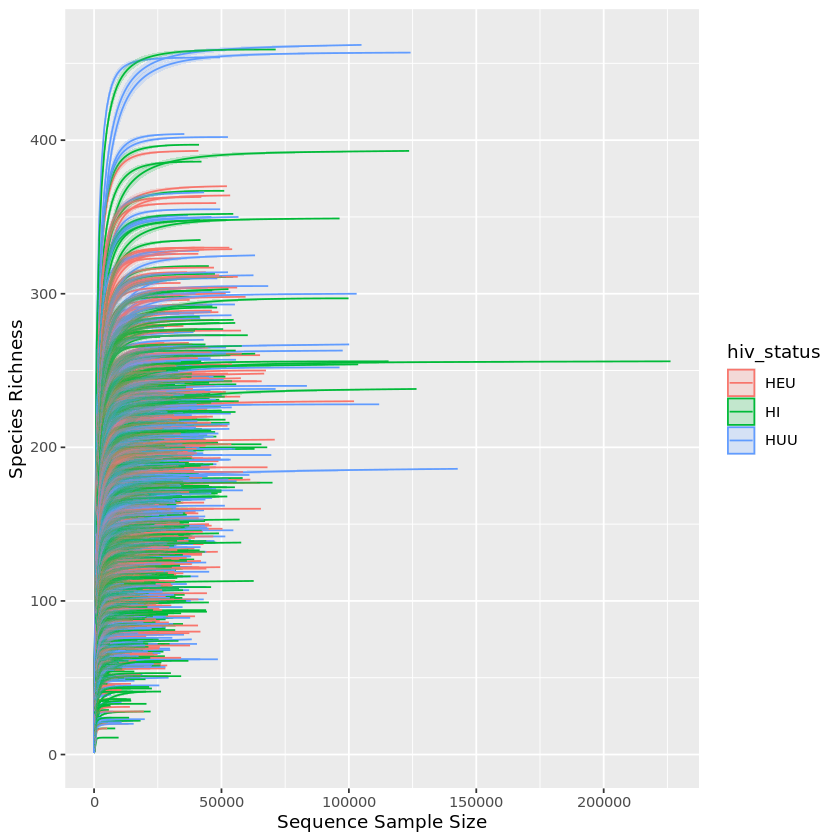

png 
  2

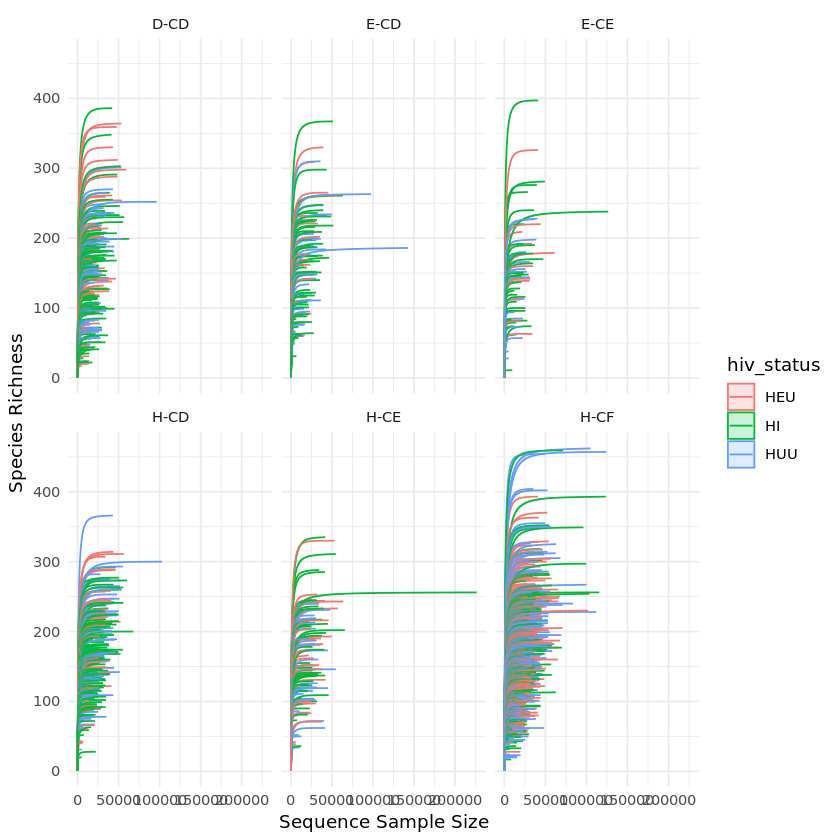

In [21]:
options(warn=-1) # suppress warnings
p <- ggrare(ps.dat, step = 1000, color = "hiv_status", se = TRUE)
p <- p + facet_wrap(~aliquot_type)
p + theme_minimal()
pdf("img/rarefaction_plots.pdf")
p + theme_minimal()
dev.off()
options(warn=0) # back on

In [22]:
# save image
save.image("diversity.RData")